In [1]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np
import networkx as nx
import asyncio
import aiohttp
import matplotlib.pyplot as plt
import powerlaw


## Ideas for the research

**With 1448 characters in a huge anime franchise and fictional world, we were intrigued to see, if one could make an overview of the characters and the interactions. Whether it would be possible to make sense of the characters and see how much both they and their respective villages interact.**

**Further to see how the episodes and the development of the series progresses. Due to many wars and conflicts in the series that spans over several fictional years, we wanted to test out with a sentiment analysis on the descriptions for each episode**

## Get the cleaned links from the json file

In [2]:
import os
import json

data_folder_path = '../data/'

all_data = {}

for filename in os.listdir(data_folder_path):
    if filename.endswith(".json"):
        json_file_path = os.path.join(data_folder_path, filename)
        
        with open(json_file_path, 'r') as file:
            all_data[os.path.splitext(filename)[0]] = json.load(file)


## Building the network

**Note: The hyperlinks names cant always be copy pasted to get the correct link and name**

**Assigning attributes according to the info box for each character**

**We have to replace the JSON file of links that have the key as character names with underscore but the links are with whitespace (no underscore). Therefore, we have to make all of it underscore so we can find and match with the names list that is all in underscore**

In [3]:
G = nx.DiGraph()

In [4]:
underscore_JSON_links = {}
for character in all_data['characters_list']:
    underscore_JSON_links[character] = [link.replace(" ", "_") for link in all_data['characters_links_corrected'][character]]

### Standardize all attributes in the character infobox 

In [5]:
for character in all_data['characters_list']:
    
    G.add_node(character)
    
    if character == "Zetsu":
        continue

    for key, values in all_data['characters_infobox'][character].items():
        nx.set_node_attributes(G,{character: values}, name = key)
                
    for character2 in all_data['characters_list']:
        if character2 in underscore_JSON_links[character]:
            G.add_edge(character, character2)

In [6]:
print("The directed network constitutes of",len(G.nodes),\
"nodes (naruto characters) and", len(G.edges), "edges (links)")

The directed network constitutes of 1448 nodes (naruto characters) and 13421 edges (links)


**The most popular characters**

In [7]:
in_degrees_dict = dict(G.in_degree())
out_degrees_dict = dict(G.out_degree())

sorted_in = sorted(in_degrees_dict, key= lambda x: in_degrees_dict[x], reverse=True)
sorted_out = sorted(out_degrees_dict, key= lambda x: out_degrees_dict[x], reverse=True)

top_5_in = sorted_in[:5]
top_5_out = sorted_out[:5]

In [8]:
print("Top 5 most connected characters with the highest in-degrees:")
for character in top_5_in:
    print(character, ":", in_degrees_dict[character])
    
print("\nTop 5 most connected characters with the highest out-degrees:")
for character in top_5_out:
    print(character, ":", out_degrees_dict[character])

Top 5 most connected characters with the highest in-degrees:
Naruto_Uzumaki : 638
Sasuke_Uchiha : 310
Kakashi_Hatake : 271
Sakura_Haruno : 205
Orochimaru : 203

Top 5 most connected characters with the highest out-degrees:
Naruto_Uzumaki : 172
Boruto_Uzumaki : 146
Kakashi_Hatake : 137
Sakura_Haruno : 124
Sasuke_Uchiha : 119


# ---Plotting the degree distributions, does it seem random or is there something scale free?----

In [9]:
in_degree = list(in_degrees_dict.values())
out_degree = list(out_degrees_dict.values())

In [10]:
frequency_in = []
in_deg_unique = np.unique(in_degree)

for degree in in_deg_unique:
    count = in_degree.count(degree)
    frequency_in.append(count)

In [11]:
frequency_out = []
out_deg_unique = np.unique(out_degree)

for degree in out_deg_unique:
    count = out_degree.count(degree)
    frequency_out.append(count)

In [12]:
min_x_lim = min(in_degree + out_degree) - 5
max_x_lim = max(in_degree + out_degree) + 5

min_y_lim = 0
max_y_lim = max(frequency_in + frequency_out) + 5

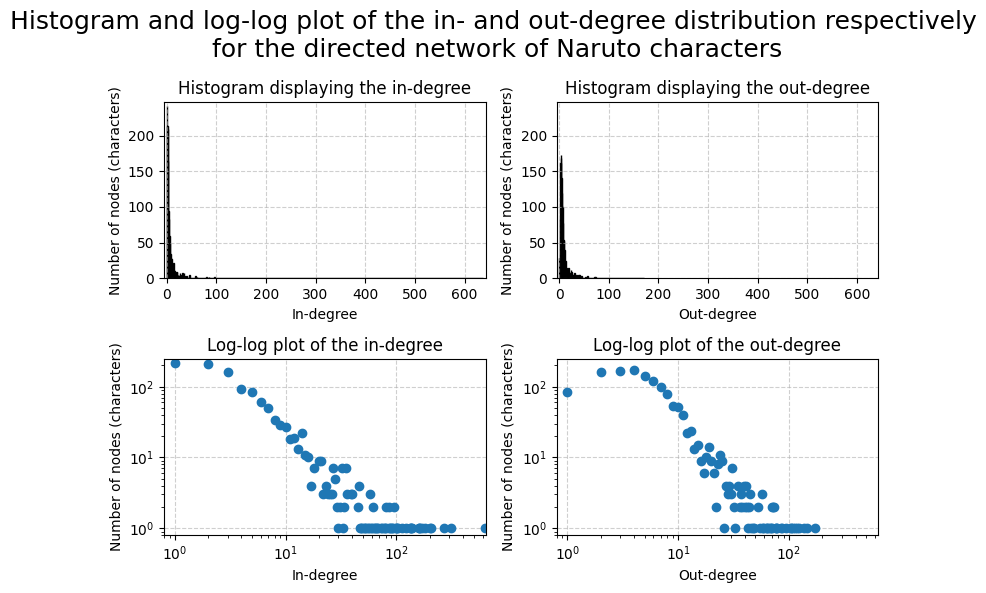

In [13]:
# Plotting the distribution both by histogram and a loglog plot
plt.figure(figsize=(8, 6))
############################################## For the histograms ##########################################################
plt.subplot(2, 2, 1)
plt.hist(in_degree, bins = range(min(in_degree), max(in_degree) + 1,1), edgecolor = 'black')
plt.grid(True, linestyle='--', alpha=0.6, zorder=0)
plt.xlim(min_x_lim, max_x_lim)
plt.ylim(min_y_lim, max_y_lim)
plt.title("Histogram displaying the in-degree")
plt.xlabel("In-degree")
plt.ylabel("Number of nodes (characters)")


plt.subplot(2, 2, 2)
plt.hist(out_degree, bins = range(min(out_degree), max(out_degree) + 1,1), edgecolor = 'black')
plt.grid(True, linestyle='--', alpha=0.6, zorder=0)
plt.xlim(min_x_lim, max_x_lim)
plt.ylim(min_y_lim, max_y_lim)
plt.title("Histogram displaying the out-degree")
plt.xlabel("Out-degree")
plt.ylabel("Number of nodes (characters)")

############################################## For the loglog plot ##########################################################
plt.subplot(2, 2, 3)
plt.loglog(in_deg_unique, frequency_in, 'o')
plt.grid(True, linestyle='--', alpha=0.6, zorder=0)
plt.xlim(0.8, max_x_lim)
plt.ylim(0.8, max_y_lim)
plt.title("Log-log plot of the in-degree")
plt.xlabel("In-degree")
plt.ylabel("Number of nodes (characters)")

plt.subplot(2, 2, 4)
plt.loglog(out_deg_unique, frequency_out, 'o')
plt.grid(True, linestyle='--', alpha=0.6, zorder=0)
plt.xlim(0.8, max_x_lim)
plt.ylim(0.8, max_y_lim)
plt.title("Log-log plot of the out-degree")
plt.xlabel("Out-degree")
plt.ylabel("Number of nodes (characters)")

plt.suptitle("Histogram and log-log plot of the in- and out-degree distribution respectively\n for the directed network of Naruto characters", fontsize = 18)
plt.tight_layout()
plt.show()

In [30]:
# Extracting the exponent
in_degree_fit = powerlaw.Fit(in_degree)
out_degree_fit = powerlaw.Fit(out_degree)

in_degree_exponent = in_degree_fit.alpha
out_degree_exponent = out_degree_fit.alpha

print("The degree exponent for the in-degree distribution is:", round(in_degree_exponent,4))
print("The degree exponent for the out-degree distribution is:", round(out_degree_exponent,4))

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
The degree exponent for the in-degree distribution is: 2.0814
The degree exponent for the out-degree distribution is: 2.4935


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


# Visualizing the network according to Village


**In this part, the network of Naruto characters are colored according to the village they are from. There is a total of 39 villages, however the 'Five Great Shinobi Countries' in the series constitutes of five major villages. These are Konohagakure, Sunagakure, Kirigakure, Kumogakure and Iwagakure. Hence the characters (nodes) from these villages are colored and the rest characters from the remaining 34 villages are colored grey.**

In [47]:
# The five great nations

five_great_node_dict = {
    "Konohagakure": "red",  # Set the color for Konohagakure to white
    "Sunagakure": "green",      # Set the color for other villages as needed
    "Kirigakure": "blue",
    "Kumogakure": "yellow",
    "Iwagakure": "#8B4513",
    # Add default color for villages not specified
    "default": "black"
}

five_great_edges_dict = {
    "Konohagakure-Konohagakure": "red", 
    "Sunagakure-Sunagakure": "green", 
    "Kirigakure-Kirigakure": "blue", 
    "Kumogakure-Kumogakure": "yellow",
    "Iwagakure-Iwagakure": "#8B4513",
    # Add default color for edges not specified
    "default": "gray"
}

In [ ]:
def color_nodes_by_affiliation(G, node_colors_dict):
    """
    Color nodes in the graph based on their affiliation.

    Parameters:
    - G: NetworkX graph
    - node_colors_dict: Dictionary mapping village names to colors

    Returns:
    - List of node colors
    """
    node_colors = []
    for node in G.nodes:
        affiliation = G.nodes[node].get('Affiliation', [])

        if affiliation:
            for village in affiliation:
                if village in node_colors_dict:
                    node_colors.append(node_colors_dict[village])
                    break  # Stop checking other villages for this node
            else:
                node_colors.append(node_colors_dict["default"])  # Assign default color if no matching village is found
        else:
            node_colors.append(node_colors_dict["default"])

    return node_colors


def color_edges_by_affiliation(G, edge_colors_dict):
    """
    Color edges in the graph based on the affiliation of their nodes.

    Parameters:
    - G: NetworkX graph
    - edge_colors_dict: Dictionary mapping village names to edge colors

    Returns:
    - List of edge colors
    """
    edge_colors = []
    for edge in G.edges:
        node1, node2 = edge
        affiliation1 = G.nodes[node1].get('Affiliation', [])
        affiliation2 = G.nodes[node2].get('Affiliation', [])

        # Check if both nodes have affiliation
        if affiliation1 and affiliation2:
            common_affiliation = set(affiliation1) & set(affiliation2)
            if common_affiliation:
                for village in common_affiliation:
                    edge_key = f"{village}-{village}"
                    if edge_key in edge_colors_dict:
                        edge_colors.append(edge_colors_dict[edge_key])
                        break  # Stop checking other villages for this edge
                else:
                    edge_colors.append(edge_colors_dict["default"])  # Assign default color if no matching village is found
            else:
                edge_colors.append(edge_colors_dict["default"])  # Assign default color if no common affiliation
        else:
            edge_colors.append(edge_colors_dict["default"])  # Assign default color if one or both nodes have no affiliation

    return edge_colors

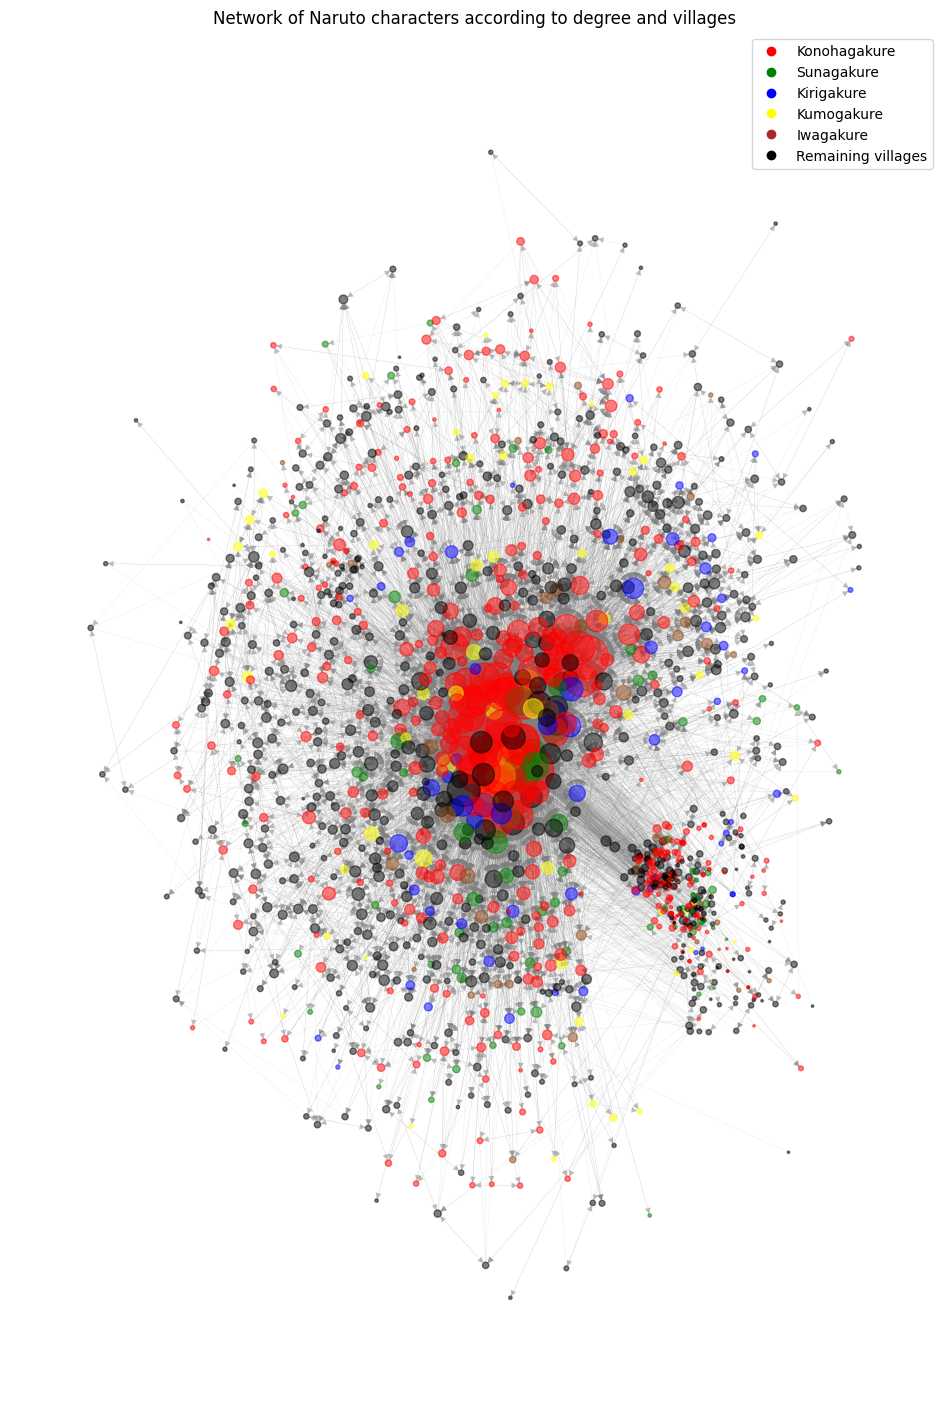

In [50]:
def draw_graph(G, node_colors_dict, edge_colors_dict, id_color_dict):
    
    node_colors = color_nodes_by_affiliation(G, five_great_node_dict)
    edge_colors = color_edges_by_affiliation(G, five_great_edges_dict)

    # Drawing graph
    degree_dict = dict(G.degree)
    plt.figure(figsize=(12, 18))
    plt.title("Network of Naruto characters according to degree and villages")
    position = nx.kamada_kawai_layout(G, scale=8.0)  # Adjust the scale value to control node distance
    nx.draw(
        G,
        pos=position,
        node_size=[v * 3 for v in degree_dict.values()],
        width=0.1,
        node_color=node_colors,
        edge_color=edge_colors,
        alpha=0.5
    )

    # For legend
    markers = [plt.Line2D([0, 0], [0, 0], color=color, marker='o', linestyle='') for color in id_color_dict.values()]

    plt.legend(markers, id_color_dict.keys(), numpoints=1)

    plt.show()

# Define your id_color_dict
id_color_dict = {"Konohagakure": "Red", "Sunagakure": "Green", "Kirigakure": "Blue", "Kumogakure": "Yellow", "Iwagakure": "Brown", "Remaining villages": "Black"}

# Call the function with the id_color_dict
draw_graph(G, five_great_node_dict, five_great_edges_dict, id_color_dict)